In [ ]:
!pip install everywhereml>=0.2.12 --quiet

In [ ]:
import io
import os
import csv
import joblib
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from numpy.ma.core import append
from scipy.stats import kurtosis, skew

# Sklearn dependence
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC

# Tensorflow dependence
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model

# To arduino
# from everywhereml.code_generators.tensorflow import tf_porter

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Predicted label')
    plt.xlabel('True label')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Preprocess - get signals

In [ ]:
# subject_folders = os.listdir('/content/drive/MyDrive/Taller de proyectos/SisFall_dataset')

# new_csv = [[]]
# for i in tqdm(subject_folders):
#     temp_folder = []
#     if i.endswith('.txt'):  # Omitir archivos .txt
#         continue
#     actual_folder_path = '/content/drive/MyDrive/Taller de proyectos/SisFall_dataset/' + i
#     temp_folder = os.listdir(actual_folder_path)
#     number_files = len(temp_folder)
#     for j in temp_folder:
#         if not j.endswith('.txt'):  # Omitir archivos .txt
#             continue
#         file = io.BytesIO(open(actual_folder_path + '/' + j, 'rb').read().replace(b';',b''))
#         data = np.genfromtxt(file, dtype=int, delimiter=',')
#         line = []
#         for col in range(len(data.T)):
#             min_ = min(data[:, col])
#             max_ = max(data[:, col])
#             mean_ = np.mean(data[:, col])
#             variance = np.var(data[:, col])

#             line.append(min_)
#             line.append(max_)
#             line.append(mean_)
#             line.append(variance)
#             line.append(k)
#             line.append(s)

#         if (j[0] == "F"):
#             line.append(1)
#         else:
#             line.append(0)


#         new_csv.append(line)
#         file.close()


In [ ]:
# with open('/content/drive/MyDrive/Taller de proyectos/test2.csv', 'w', newline='') as csvfile:
#     spamwriter = csv.writer(csvfile, delimiter=',', quoting=csv.QUOTE_MINIMAL)
#     spamwriter.writerows(new_csv)

# Dataset

In [ ]:
path_df = '/content/drive/MyDrive/Taller de proyectos/test2.csv'
dataframe = pd.read_csv(path_df)

descriptive = dataframe.iloc[:, :36].values ### Giro+acc 6 mediciones XYZ * 6 valores (max, min)
target = dataframe.iloc[:, 54].values ### Giro+acc

X_train, X_test, y_train, y_test = train_test_split(descriptive, target, test_size = 0.20, random_state = 1234)

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
y_train = np.expand_dims(y_train, axis=1)
y_test = np.expand_dims(y_test, axis=1)

print(X_train.shape)
print(y_train.shape)

(3612, 36, 1)
(3612, 1)


In [ ]:
# X_test[0].shape
X_test[0]

array([[-9.30000000e+01],
       [ 6.46000000e+02],
       [ 1.12031000e+02],
       [ 1.51086154e+04],
       [-9.44770646e-01],
       [ 4.63268597e-01],
       [-2.61000000e+02],
       [ 2.95000000e+02],
       [-1.23303667e+02],
       [ 1.79438201e+04],
       [-1.45769549e+00],
       [ 3.24141839e-01],
       [-4.40000000e+02],
       [ 6.20000000e+01],
       [-3.53193333e+01],
       [ 5.81477203e+03],
       [ 3.27258084e+00],
       [-1.12334527e+00],
       [-3.29300000e+03],
       [ 6.12000000e+02],
       [-6.50823333e+01],
       [ 2.04259444e+05],
       [ 2.67079973e+01],
       [-4.98249269e+00],
       [-1.90200000e+03],
       [ 3.40200000e+03],
       [ 8.00613333e+01],
       [ 1.62843245e+05],
       [ 3.07912103e+01],
       [ 4.01983134e+00],
       [-3.50000000e+02],
       [ 2.14800000e+03],
       [ 3.51353333e+01],
       [ 5.47415617e+04],
       [ 3.37131816e+01],
       [ 5.60611071e+00]])

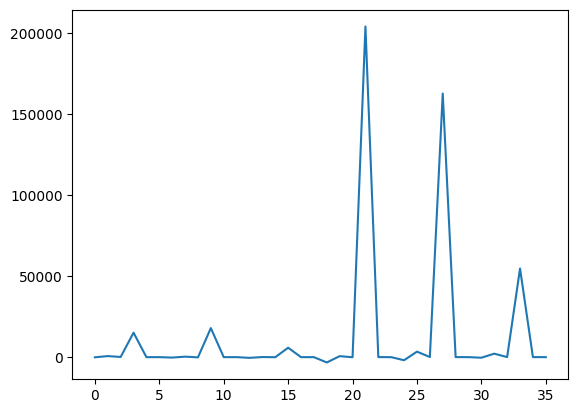

In [ ]:
plt.plot(X_test[0])

# Model

In [ ]:
timesteps = 36  # Número de pasos de tiempo
input_dim = 1  # Dimensión de cada paso de tiempo
num_classes = 2

# Definir la arquitectura de la red LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(timesteps, input_dim)))  # Cambiar el número de unidades LSTM según sea necesario
model.add(Dense(num_classes, activation='softmax'))  # Cambiar el número de clases según tu tarea de clasificación

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Codificar las etiquetas en one-hot encoding
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

# Training

In [ ]:
# Definir el objeto ModelCheckpoint para guardar el modelo
checkpoint1 = ModelCheckpoint('/content/drive/MyDrive/Taller de proyectos/checkpoints/modelo_epoch_10_v2.h5', save_weights_only=False, save_best_only=False, period=10)
checkpoint2 = ModelCheckpoint('/content/drive/MyDrive/Taller de proyectos/checkpoints/modelo_epoch_30_v2.h5', save_weights_only=False, save_best_only=False, period=30)
checkpoint3 = ModelCheckpoint('/content/drive/MyDrive/Taller de proyectos/checkpoints/modelo_epoch_50_v2.h5', save_weights_only=False, save_best_only=False, period=50)

# Entrenar el modelo
history = model.fit(X_train, y_train_encoded, batch_size=10, epochs=50, callbacks=[checkpoint1, checkpoint2, checkpoint3])


# Prediction

In [ ]:
# Cargar el modelo desde un archivo
model = load_model('/content/drive/MyDrive/Taller de proyectos/checkpoints/modelo_epoch_50_v2.h5')

# Evaluar el modelo
loss, accuracy = model.evaluate(X_test, y_test_encoded)

# Realizar predicciones
predictions = model.predict(X_test)

# Predicción de clases
pred_classes = np.argmax(predictions, axis=1)


29/29 [==============================] - 2s 6ms/step


In [ ]:
y_test_encoded[0]

array([0., 1.], dtype=float32)

In [ ]:
X_test[0]

array([[-9.30000000e+01],
       [ 6.46000000e+02],
       [ 1.12031000e+02],
       [ 1.51086154e+04],
       [-9.44770646e-01],
       [ 4.63268597e-01],
       [-2.61000000e+02],
       [ 2.95000000e+02],
       [-1.23303667e+02],
       [ 1.79438201e+04],
       [-1.45769549e+00],
       [ 3.24141839e-01],
       [-4.40000000e+02],
       [ 6.20000000e+01],
       [-3.53193333e+01],
       [ 5.81477203e+03],
       [ 3.27258084e+00],
       [-1.12334527e+00],
       [-3.29300000e+03],
       [ 6.12000000e+02],
       [-6.50823333e+01],
       [ 2.04259444e+05],
       [ 2.67079973e+01],
       [-4.98249269e+00],
       [-1.90200000e+03],
       [ 3.40200000e+03],
       [ 8.00613333e+01],
       [ 1.62843245e+05],
       [ 3.07912103e+01],
       [ 4.01983134e+00],
       [-3.50000000e+02],
       [ 2.14800000e+03],
       [ 3.51353333e+01],
       [ 5.47415617e+04],
       [ 3.37131816e+01],
       [ 5.60611071e+00]])

In [ ]:
target_names = ['Normal Activity', 'Fall']
print(classification_report(y_test, pred_classes, target_names=target_names))

                 precision    recall  f1-score   support

Normal Activity       0.95      0.96      0.96       533
           Fall       0.94      0.93      0.94       371

       accuracy                           0.95       904
      macro avg       0.95      0.95      0.95       904
   weighted avg       0.95      0.95      0.95       904



# History

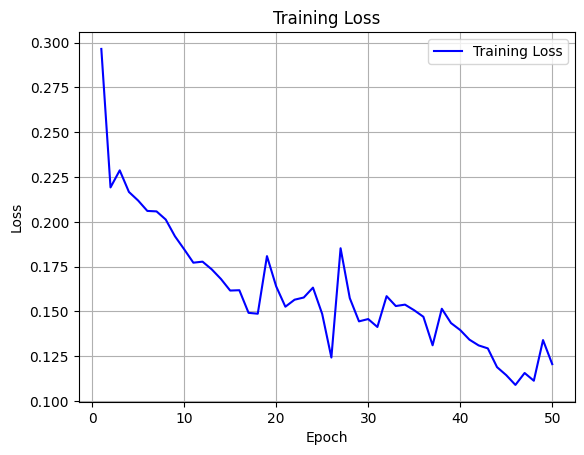

In [ ]:
# Obtener los valores de la pérdida del historial
loss_values = history.history['loss']

# Crear un gráfico de la pérdida durante el entrenamiento
plt.plot(range(1, len(loss_values) + 1), loss_values, 'b-', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid()
plt.show()

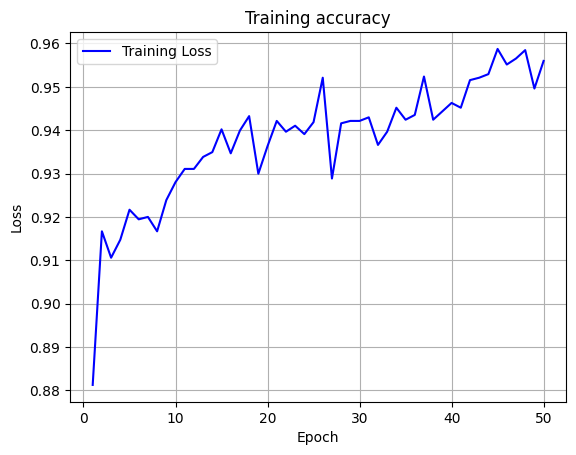

In [ ]:
# Obtener los valores de la pérdida del historial
loss_values = history.history['accuracy']

# Crear un gráfico de la pérdida durante el entrenamiento
plt.plot(range(1, len(loss_values) + 1), loss_values, 'b-', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training accuracy')
plt.legend()
plt.grid()
plt.show()

# To Arduino

In [ ]:
# Obtener la ruta al directorio guardado
saved_model_dir = '/content/drive/MyDrive/Taller de proyectos/checkpoints/modelo_epoch_50_v2.h5'

# Cargar el modelo entrenado
model = tf.keras.models.load_model(saved_model_dir)

# Convertir el modelo a TensorFlow Lite con ajustes para evitar el error
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False  # Deshabilitar la conversión de operaciones de lista de tensores
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

# Guardar el modelo TensorFlow Lite en un archivo
open('FallDetector.tflite', 'wb').write(tflite_model)
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
# tflite_model = converter.convert()

# # Save the model to disk
# open("FallDetector.tflite", "wb").write(tflite_model)


29560

In [ ]:
!apt-get -qq install xxd



In [ ]:
!echo "const unsigned char model[] = {" > /content/FallDetector.h
!cat /content/FallDetector.tflite | xxd -i >> /content/FallDetector.h
!echo "};" >> /content/FallDetector.h

In [ ]:
!xxd -i FallDetector.tflite > FallDetector.h
!cat FallDetector.h

unsigned char FallDetector_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00,
  0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00, 0x0c, 0x00, 0x00, 0x00,
  0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x8c, 0x00, 0x00, 0x00, 0xdc, 0x00, 0x00, 0x00, 0x88, 0x52, 0x00, 0x00,
  0x98, 0x52, 0x00, 0x00, 0xa0, 0x71, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x22, 0x9a, 0xff, 0xff,
  0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x3c, 0x00, 0x00, 0x00,
  0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f,
  0x64, 0x65, 0x66, 0x61, 0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x5c, 0x9b, 0xff, 0xff, 0x1f, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x08, 0x00, 0x00, 0x00, 0x64, 0x65, 0x6e, 0x73,
  0x65, 0x5f, 0x31, 0x30, 0x00, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0x2a, 0x9a, 0xff, 0xff, 0x04, 0x00, 0x00, 0x00